# Convolutional Neural Networks

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/deep-learning-intro/">https://d9w.github.io/deep-learning-intro/</a><br>Based on the Supaero Data Science Deep Learning class: https://supaerodatascience.github.io/deep-learning/

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline
import matplotlib.pyplot as plt

The main factor which makes deep learning so useful for computer vision is the use of convolutions. Convolutional networks exploit the fact that the data is actually an image in the learning while decreasing the number of weights in the network. To do this, they define **convolution filters** that brush across the image. Such a filter defines a so-called **feature map** that shares the weights of the filter. The result of applying a feature map on an image is a new image of lower resolution, where each pixel is the result of the convolution of the filter with a set of pixels from the input image, as illustrated on the figure below. The Stanford class [CS231n](http://cs231n.github.io/convolutional-networks/) also has an excellent demo.

<img src="img/convnet.gif" width="700px">

Convolutional layers extract important features from previous layers, transforming the image space into a feature space where each block of neurons corresponds to a feature set rather than a group of pixels. To aggregate these features, select the most important ones, and reduce the dimensionality of our network, we'll use the **pooling** operator. Pooling is the operation of down-sampling the image by grouping together certain pixels. The most common pooling operation takes the maximum value over a certain window. Max pooling has been shown to better separate features which are rare in the data.

Boureau, Y-Lan, Jean Ponce, and Yann LeCun. "A theoretical analysis of feature pooling in visual recognition." Proceedings of the 27th international conference on machine learning (ICML-10). 2010. [pdf](https://www.di.ens.fr/willow/pdfs/icml2010b.pdf)

<img src="img/maxpool.png">

One of the advantages of convolution is translational invariance: a feature can appear in different parts of an image, and the network will still detect it. Here's a simple example:

<img src="img/invariance.png">

When defining a convolutional layer, we define the number of channels, where a channel is one slice of neurons. Our input image has one channel - the dimensions are 28 by 28 by 1. A color image has three channels, red green and blue. Using convolution, we'll convert our image of 28 by 28 by 1 into a number of different channels, which we call feature maps. The other parameter we define is the size of the kernel - how large is the filter we're passing over the previous layer. 

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`

The options of stride, padding, dilation, and groups are further explained in the [documentation](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20conv2d#torch.nn.Conv2d). [This page](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) shows an illustration of these different options.

In [2]:
rng = np.random.default_rng()
data = rng.integers(-5, 5, (1, 3, 3))
conv_W = np.array([[np.identity(2)]]) #np.ones((1, 1, 2, 2))
conv_b = np.zeros(1)
m = torch.nn.Conv2d(1, 1, 2, stride=1)
m.weight = torch.nn.Parameter(torch.tensor(conv_W, dtype=torch.float))
m.bias = torch.nn.Parameter(torch.tensor(conv_b, dtype=torch.float))
input = torch.tensor(np.array([data]), dtype=torch.float)
output = m(input)
print("Input:", input)
print("Weight:", m.weight)
print("Bias:", m.bias)
print("Output:", output)

Input: tensor([[[[ 1.,  3.,  1.],
          [-1., -4.,  4.],
          [ 4., -1., -5.]]]])
Weight: Parameter containing:
tensor([[[[1., 0.],
          [0., 1.]]]], requires_grad=True)
Bias: Parameter containing:
tensor([0.], requires_grad=True)
Output: tensor([[[[-3.,  7.],
          [-2., -9.]]]], grad_fn=<ThnnConv2DBackward>)


We will change our network to have the following specifications: a convolutional layer with 32 channels and a kernel size of 3, a second convolutional layer with 64 channels and a kernel size of 3, then two hidden layers.

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.relu(x)
        return output

We will redefine the train and validation methods to test this new model.

In [4]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

full_trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
trainset, full_validset = torch.utils.data.random_split(full_trainset, (10000, 50000))
validset, _ = torch.utils.data.random_split(full_validset, (1000, 49000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False, num_workers=2)

In [5]:
def train(net):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

In [6]:
def get_valid_predictions(net):
    validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False)
    all_labels = np.array([])
    predictions = np.array([])
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, labels.numpy())
            predictions = np.append(predictions, predicted.numpy())
    return all_labels, predictions

In [7]:
net = ConvNet()
train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))

Accuracy:  0.27


<div class="alert alert-info">
    <h3>Discussion</h3>
    
We previously defined backpropagation for feed-forward networks which used the gradient of the weighted sum and neural activation function. Can backpropagation still work with these two layer types, convolution and pooling? How? What requirement is there for the operators performed by each layer?
</div>

# Improving Optimization

Just to review, training a neural network is a function of maximizing some objective function $Q$; it is a process of optimization. $Q$ can be, for example, a MSE Loss function:
$$
Q_i(\theta) = (X(\theta, i) - h_i)^2\\
Q(\theta) = \frac{1}{n}\sum_{i=1}^n Q_i(\theta)
$$
So far, we've been using SGD for this optimization:

In [8]:
net = ConvNet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In other words, we're doing our weight ($\theta$) update according to the following:

$$
\Delta \theta^{(t+1)} \leftarrow \alpha\Delta \theta^{(t)}-\eta\nabla Q_i (\theta^{(t)})\\
\theta^{(t+1)} \leftarrow \theta^{(t)} + \Delta \theta^{(t+1)}
$$

These two hyperparameters, learning rate ($\alpha$) and momentum ($\eta$), change how the neural network minimizes the loss and can have drastic impact on the learning.

<img src="https://github.com/SupaeroDataScience/deep-learning/raw/main/deep/img/sgd.gif" width="80%">

A popular optimizer is the Adaptive Moment Estimation ([Adam](https://arxiv.org/pdf/1412.6980.pdf)) optimizer. This optimizer takes into account the recent weight changes when making a new update, storing an exponentially decaying average of past gradients to create momentum and storing an exponentially decaying average of past squared gradients to avoid diminishing learning rates.

$$
m_\theta^{(t+1)} \leftarrow \beta_1 m_\theta^{(t)} + (1-\beta_1) \nabla Q_i(\theta^{(t)})\\
v_\theta^{(t+1)} \leftarrow \beta_2 v_\theta^{(t)} + (1-\beta_2)(\nabla Q_i(\theta^{(t)}))^2\\
\hat{m}_\theta = \frac{m_\theta^{(t+1)}}{1-\beta_1^t}\\
\hat{v}_\theta = \frac{v_\theta^{(t+1)}}{1-\beta_2^t}\\
\theta^{(t+1)} \leftarrow \theta^{(t)} - \eta\frac{\hat{m}_\theta}{\sqrt{\hat{v}_\theta}+\epsilon}
$$

While this optimizer can often perform better than SGD, it introduces new hyperparameter choices: $\beta_1$ (update to $\hat{m}$), $\beta_2$ (update to $\hat{v}$), and $\epsilon$ (ratio between $\hat{m}$ and $\hat{v}$). However, as with SGD, the choice of hyperparameters can greatly affect the training.

<img src="https://github.com/SupaeroDataScience/deep-learning/raw/main/deep/img/adam.gif" width="80%">

Now that we have a convolutional neural network and a better optimization method, let's see if we can improve the training on FashionMNIST. We will train for 20 epochs and measure training and validation error during the training.

In [9]:
def validation(net):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

In [10]:
def train(net):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    train_history = []
    valid_history = []
    for epoch in range(20):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
    return train_history, valid_history

In [11]:
def plot_train_val(train, valid):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=512, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()

In [13]:
net = ConvNet()
train_history, valid_history = train(net)

Epoch 00: train loss 31.07301, validation loss 1.63908
Epoch 01: train loss 13.82224, validation loss 1.09342
Epoch 02: train loss 9.98887, validation loss 0.94976
Epoch 03: train loss 8.69393, validation loss 0.74668
Epoch 04: train loss 7.42910, validation loss 0.71746
Epoch 05: train loss 6.87183, validation loss 0.65020
Epoch 06: train loss 6.15007, validation loss 0.68027
Epoch 07: train loss 5.61775, validation loss 0.64668
Epoch 08: train loss 5.16522, validation loss 0.62450
Epoch 09: train loss 4.49845, validation loss 0.62316
Epoch 10: train loss 4.04737, validation loss 0.58827
Epoch 11: train loss 3.84642, validation loss 0.63983
Epoch 12: train loss 3.35872, validation loss 0.61238
Epoch 13: train loss 3.01734, validation loss 0.59106
Epoch 14: train loss 2.67947, validation loss 0.58394
Epoch 15: train loss 2.44330, validation loss 0.62803
Epoch 16: train loss 2.07286, validation loss 0.66674
Epoch 17: train loss 1.66910, validation loss 0.74386
Epoch 18: train loss 1.496

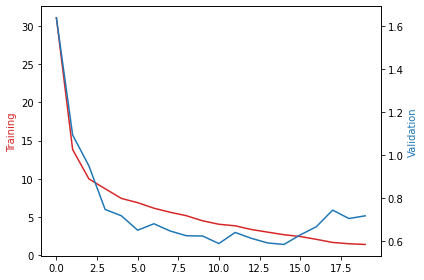

In [14]:
plot_train_val(train_history, valid_history)

The model is training well! We might notice overfitting, which is the problem of learning the training distribution while getting further from the validation distribution. This is a problem with deep learning but there are many solutions such as dropout to combat it. Let's see how the model scores on the validation set.

In [15]:
from sklearn.metrics import accuracy_score, classification_report
y_valid, predictions = get_valid_predictions(net)
labels_text = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
print('Accuracy: ', accuracy_score(predictions, y_valid))
print(classification_report(predictions, y_valid, target_names=labels_text))

Accuracy:  0.894
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.86      0.86        90
     Trouser       0.95      0.97      0.96       107
    Pullover       0.75      0.85      0.80        93
       Dress       0.92      0.84      0.88       107
        Coat       0.87      0.71      0.78       118
      Sandal       0.99      0.97      0.98       109
       Shirt       0.64      0.78      0.70        69
     Sneaker       0.93      0.99      0.96        86
         Bag       0.98      0.99      0.99       102
  Ankle boot       0.98      0.96      0.97       119

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000

